In [1]:
# Following packages are installed
# pip install folium
# pip install geopy
# pip install lxml
# pip install wget

In [2]:
import lxml
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
import folium
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import requests
import wget

# 1. Get Venue Data

In [3]:
#import the data
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
req=pd.read_html(url)
toronto=req[0]

df_toronto=toronto[toronto['Borough']!='Not assigned'].reset_index(drop=True)
df_toronto.head()

Postal Code           Borough                                 Neighborhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [4]:
geourl='http://cocl.us/Geospatial_data'
geodata=pd.read_csv(geourl)

df2=df_toronto.merge(geodata,on='Postal Code')
df2.head()

Postal Code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

In [5]:
city = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city)
lat = location.latitude
lon = location.longitude


map_toronto = folium.Map(location=[lat, lon], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# 2. Get Venue information from Foursquare

In [10]:
CLIENT_ID = '2OMIVBGRDZ4GVNN4YNWCNZUZ5VJNHRYFMJOPWS5Y5E3D53QV' 
CLIENT_SECRET = 'V3E1N5UH5WVUM5DXEJPVUR2YXDQQUTQX0LUOJMZ01FGENVYY' 
VERSION = '20180605'

LIMIT=100
radius=800

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                    'id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
toronto_venues = getNearbyVenues(names=df2['Neighborhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [14]:
#Filter out venues that are cafe or coffee shops
df_cat=toronto_venues[toronto_venues['Venue Category'].str.contains('Café|Coffee')].reset_index(drop=True)
df_cat2=toronto_venues[toronto_venues['Venue Category'].str.contains('Café')].reset_index(drop=True)
df_cat.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           Victoria Village              43.725882              -79.315572   
1           Victoria Village              43.725882              -79.315572   
2  Regent Park, Harbourfront              43.654260              -79.360636   
3  Regent Park, Harbourfront              43.654260              -79.360636   
4  Regent Park, Harbourfront              43.654260              -79.360636   

            Venue                        id  Venue Latitude  Venue Longitude  \
0     Tim Hortons  4bbe904a85fbb713420d7167       43.725517       -79.313103   
1         JJ Bean  571e75c0498ead458f6df160       43.720229       -79.313561   
2   Tandem Coffee  53b8466a498e83df908c3f21       43.653559       -79.361809   
3  Rooster Coffee  51853a73498e4d97a8b20831       43.651900       -79.365609   
4            Arvo  57cd9d20498e6ab8342980e2       43.649963       -79.361442   

  Venue Category  
0    Coffee Shop  
1           Café  
2    Coffee Shop  
3    Coffee Shop  
4    Coffee Shop

In [15]:
# get number of coffee shops in each neighbourhood and calculate the mean
df_neigh=df_cat[['Neighborhood','Venue']].groupby('Neighborhood').count().reset_index()
df_neigh=df_neigh.merge(df2,on='Neighborhood').rename(columns={'Venue':'Coffee shops count'})
df_sort=df_neigh.sort_values(by='Coffee shops count',ascending=False)
print(df_sort.head(6))
print(df_sort['Coffee shops count'].mean())

                              Neighborhood  Coffee shops count Postal Code  \
67                          Stn A PO Boxes                  20         M5W   
64                          St. James Town                  17         M5C   
59               Regent Park, Harbourfront                  16         M5A   
4                              Berczy Park                  16         M5E   
30  First Canadian Place, Underground city                  15         M5X   
32                Garden District, Ryerson                  15         M5B   

             Borough   Latitude  Longitude  
67  Downtown Toronto  43.646435 -79.374846  
64  Downtown Toronto  43.651494 -79.375418  
59  Downtown Toronto  43.654260 -79.360636  
4   Downtown Toronto  43.644771 -79.373306  
30  Downtown Toronto  43.648429 -79.382280  
32  Downtown Toronto  43.657162 -79.378937  
5.662790697674419


In [16]:
#download the json file
import json
geo_url='https://raw.githubusercontent.com/ag2816/Visualizations/master/data/Toronto2.geojson'
wget.download(geo_url,'/Users/xinrui/Downloads')

with open('/Users/xinrui/Downloads/Toronto2.geojson') as json_data:
    choro_data = json.load(json_data)


In [17]:
#create a choropleth map showing numbers of coffee shops
map_choro = folium.Map(location=[lat, lon], zoom_start=12)

map_choro.choropleth(
    geo_data=choro_data,
    data=df_sort,
    columns=['Postal Code', 'Coffee shops count'],
    key_on='feature.properties.CFSAUID',

    fill_color='YlOrRd', 
    fill_opacity=0.4, 
    line_opacity=0.8,
    legend_name='Number of Chinese Restaurants',
    reset=True
)

# add markers to map
for lat, lng, label in zip(df_cat['Venue Latitude'], df_cat['Venue Longitude'], df_cat['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_choro)  
       

map_choro

/opt/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## 2.1 Get restaurant information from Foursquare

In [19]:
list_rows=[]
#get likes and ratings 
for venue_id in df_cat2['id'].tolist():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venue_id, 
        CLIENT_ID, 
        CLIENT_SECRET,
        VERSION)
    getresult = requests.get(url).json()
    venue_data=getresult['response']['venue']
    venue_info=[]
    
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_info.append([venue_id,venue_name,venue_likes,venue_rating])
    except KeyError:
        pass
        
    for row in venue_info:
        list_rows.append(venue_info)
     
    
df_info = pd.DataFrame(list_rows,columns=['Info'])
df_info.head()

Info
0   [4d84d98181fdb1f7d4a704c0, Caffe Furbo, 35, 8.2]
1  [5022a0cde4b0c3bc4aff8d5c, The Black Canary Es...
2  [54d37e23498e5e29bcb35362, ODIN Cafe + Bar, 72...
3  [57fe5f64498e08c9fc55cb87, Jimmy's Coffee, 32,...
4  [4ad4c060f964a52086f720e3, 7 West Cafe, 166, 7.2]

In [20]:
#split the dataframe into 4 columns
column_names=['id','Name','Likes','Rating']
df_info=pd.DataFrame(df_info['Info'].tolist(), columns=column_names)
df_info.drop_duplicates(subset='id',inplace=True)
df_info.head()

id                           Name  Likes  Rating
0  4d84d98181fdb1f7d4a704c0                    Caffe Furbo     35     8.2
1  5022a0cde4b0c3bc4aff8d5c  The Black Canary Espresso Bar     80     8.7
2  54d37e23498e5e29bcb35362                ODIN Cafe + Bar     72     7.6
3  57fe5f64498e08c9fc55cb87                 Jimmy's Coffee     32     8.1
4  4ad4c060f964a52086f720e3                    7 West Cafe    166     7.2

In [21]:
df_merge=df_cat2.merge(df_info,on='id',how='right').drop_duplicates(subset='id').drop(columns='Venue').reset_index(drop=True)
df_merge.head()

Neighborhood  Neighborhood Latitude  \
0                    Regent Park, Harbourfront              43.654260   
1                    Regent Park, Harbourfront              43.654260   
2                    Regent Park, Harbourfront              43.654260   
3  Queen's Park, Ontario Provincial Government              43.662301   
4  Queen's Park, Ontario Provincial Government              43.662301   

   Neighborhood Longitude                        id  Venue Latitude  \
0              -79.360636  4d84d98181fdb1f7d4a704c0       43.649970   
1              -79.360636  5022a0cde4b0c3bc4aff8d5c       43.651869   
2              -79.360636  54d37e23498e5e29bcb35362       43.656739   
3              -79.389494  57fe5f64498e08c9fc55cb87       43.655827   
4              -79.389494  4ad4c060f964a52086f720e3       43.668665   

   Venue Longitude Venue Category                           Name  Likes  \
0       -79.358849           Café                    Caffe Furbo     35   
1       -79.368506           Café  The Black Canary Espresso Bar     80   
2       -79.356503           Café                ODIN Cafe + Bar     72   
3       -79.392042           Café                 Jimmy's Coffee     32   
4       -79.386830           Café                    7 West Cafe    166   

   Rating  
0     8.2  
1     8.7  
2     7.6  
3     8.1  
4     7.2

In [22]:
#Normalize the data
df_score=df_merge[['Neighborhood','Name','Likes','Rating']].merge(df_neigh,on='Neighborhood').groupby('Neighborhood').mean()
df_score.round(2)
df_score['Likes']=df_score['Likes']/df_score['Likes'].max()
df_score['Rating']=df_score['Rating']/df_score['Rating'].max()
df_score['performance']=df_score['Rating']+df_score['Likes']
df_score.reset_index(inplace=True)
df_score.head()

Neighborhood     Likes    Rating  \
0                               Bayview Village  0.064171  0.678161   
1             Bedford Park, Lawrence Manor East  0.251337  0.965517   
2                                   Berczy Park  0.433155  0.862069   
3                   Birch Cliff, Cliffside West  0.053476  0.931034   
4  Brockton, Parkdale Village, Exhibition Place  0.159091  0.813218   

   Coffee shops count   Latitude  Longitude  performance  
0                 1.0  43.786947 -79.385975     0.742332  
1                 4.0  43.733283 -79.419750     1.216854  
2                16.0  43.644771 -79.373306     1.295224  
3                 1.0  43.692657 -79.264848     0.984510  
4                13.0  43.636847 -79.428191     0.972309

Text(0, 0.5, 'Performance')

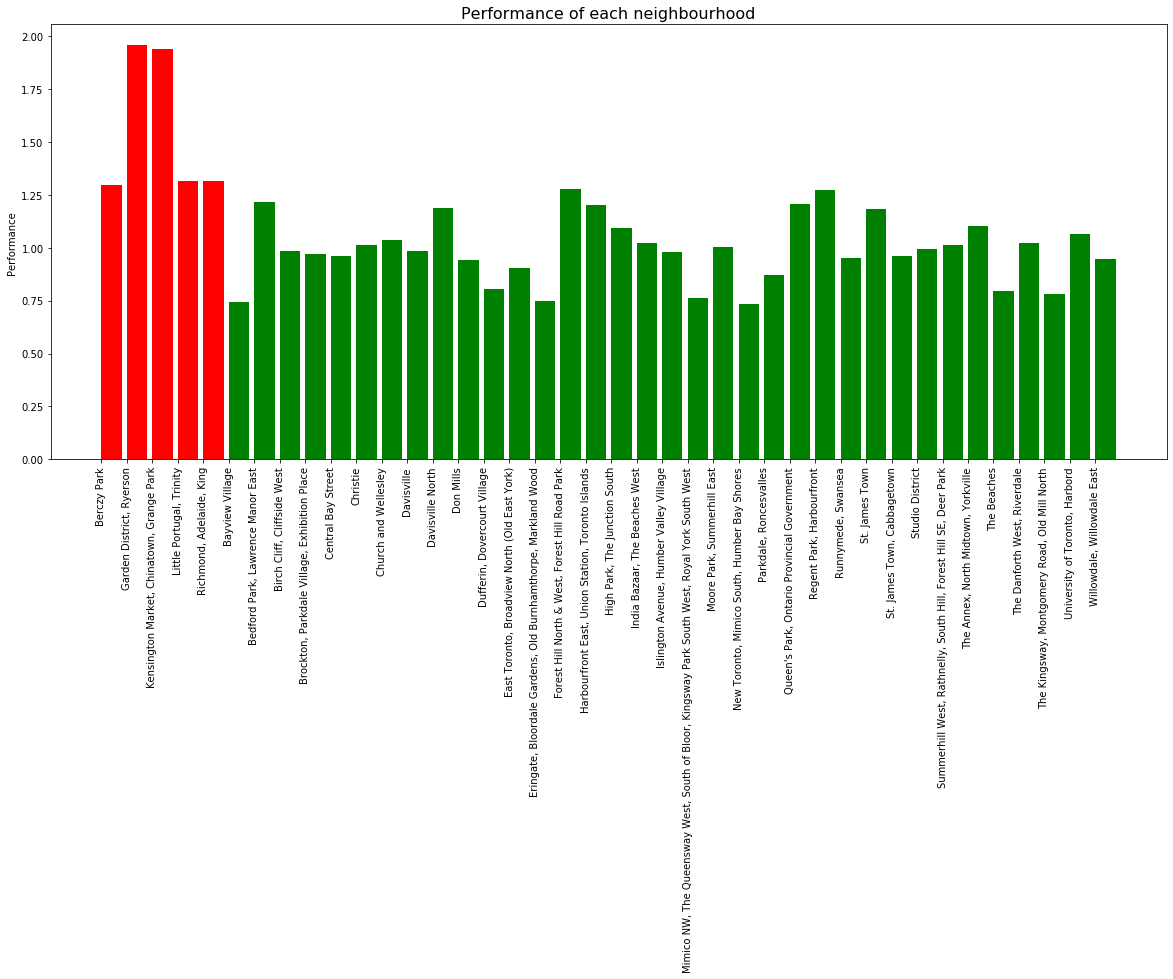

In [26]:
#Plot a bar chart showing the performance
import matplotlib.pyplot as plt
top=df_score.nlargest(5,'performance')
msk1=df_score['performance']>=top.performance.min()
msk2=df_score['performance']<top.performance.min()
plt.figure(figsize=(20,8))

# colour code the bars
plt.bar(df_score['Neighborhood'][msk1],df_score['performance'][msk1],color='red',align='edge')
plt.bar(df_score['Neighborhood'][msk2],df_score['performance'][msk2],color='green',align='edge')
plt.xticks(rotation=90)
plt.title('Performance of each neighbourhood',fontsize=16)
plt.ylabel('Performance')

# 3. K-means clustering

In [29]:
#Normalize the data
df_score['Coffee shops count']=df_score['Coffee shops count']/df_score['Coffee shops count'].max()
df_norm=df_score[['Neighborhood','performance','Coffee shops count']]
df_norm['performance']=df_norm['performance']/df_norm['performance'].max()
df_norm.set_index('Neighborhood',inplace=True)
df_norm.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


performance  Coffee shops count
Neighborhood                                                                 
Bayview Village                                  0.379156            0.058824
Bedford Park, Lawrence Manor East                0.621524            0.235294
Berczy Park                                      0.661553            0.941176
Birch Cliff, Cliffside West                      0.502852            0.058824
Brockton, Parkdale Village, Exhibition Place     0.496620            0.764706

In [30]:
#use k-means techinique to cluster into 5 tiers
kclusters=5
k_means = KMeans(init="k-means++", n_clusters=kclusters, n_init=12)
k_means.fit(df_norm)
labels = k_means.labels_
df_norm['tier'] = labels
df_norm.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Neighborhood  performance  \
0                                     Bayview Village     0.379156   
1                   Bedford Park, Lawrence Manor East     0.621524   
2                                         Berczy Park     0.661553   
3                         Birch Cliff, Cliffside West     0.502852   
4        Brockton, Parkdale Village, Exhibition Place     0.496620   
5                                  Central Bay Street     0.491322   
6                                            Christie     0.517241   
7                                Church and Wellesley     0.529553   
8                                          Davisville     0.502318   
9                                    Davisville North     0.606915   
10                                          Don Mills     0.482100   
11                       Dufferin, Dovercourt Village     0.410896   
12      East Toronto, Broadview North (Old East York)     0.463012   
13  Eringate, Bloordale Gardens, Old Burnhamthorpe...     0.383112   
14    Forest Hill North & West, Forest Hill Road Park     0.652794   
15                           Garden District, Ryerson     1.000000   
16  Harbourfront East, Union Station, Toronto Islands     0.614978   
17                      High Park, The Junction South     0.559158   
18                     India Bazaar, The Beaches West     0.522662   
19            Islington Avenue, Humber Valley Village     0.499712   
20          Kensington Market, Chinatown, Grange Park     0.990854   
21                           Little Portugal, Trinity     0.672308   
22  Mimico NW, The Queensway West, South of Bloor,...     0.389391   
23                        Moore Park, Summerhill East     0.513369   
24       New Toronto, Mimico South, Humber Bay Shores     0.375326   
25                             Parkdale, Roncesvalles     0.444918   
26        Queen's Park, Ontario Provincial Government     0.617307   
27                          Regent Park, Harbourfront     0.649706   
28                           Richmond, Adelaide, King     0.672196   
29                                 Runnymede, Swansea     0.485327   
30                                     St. James Town     0.604427   
31                        St. James Town, Cabbagetown     0.490472   
32                                    Studio District     0.507231   
33  Summerhill West, Rathnelly, South Hill, Forest...     0.518298   
34                The Annex, North Midtown, Yorkville     0.564505   
35                                        The Beaches     0.405779   
36                       The Danforth West, Riverdale     0.523415   
37      The Kingsway, Montgomery Road, Old Mill North     0.397993   
38                     University of Toronto, Harbord     0.543982   
39                        Willowdale, Willowdale East     0.482649   

    Coffee shops count  tier  
0             0.058824     1  
1             0.235294     1  
2             0.941176     4  
3             0.058824     1  
4             0.764706     0  
5             0.764706     0  
6             0.470588     3  
7             0.647059     0  
8             0.647059     0  
9             0.588235     0  
10            0.176471     1  
11            0.352941     3  
12            0.529412     3  
13            0.176471     1  
14            0.117647     1  
15            0.882353     2  
16            0.705882     0  
17            0.352941     3  
18            0.235294     1  
19            0.058824     1  
20            0.705882     2  
21            0.588235     0  
22            0.235294     1  
23            0.058824     1  
24            0.176471     1  
25            0.352941     3  
26            0.647059     0  
27            0.941176     4  
28            0.764706     0  
29            0.647059     0  
30            1.000000     4  
31            0.529412     3  
32            0.705882     0  
33            0.470588     3  
34            0.588235     0  
35            0.176471     1  
36            0.588235 

[Text(0, 0.5, 'Counts'),
 Text(0.5, 0, 'Performance'),
 Text(0.5, 1.0, 'Neighbourhood Clustering')]

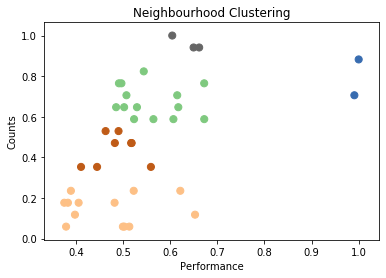

In [31]:
fig, ax = plt.subplots()
ax.scatter(df_norm.performance, df_norm['Coffee shops count'],c=k_means.labels_, s=50, cmap='Accent')
ax.set(title = "Neighbourhood Clustering",
       xlabel = "Performance", 
       ylabel = "Counts")

In [32]:
df_norm[df_norm['tier']==0]

performance  \
Neighborhood                                                     
Brockton, Parkdale Village, Exhibition Place          0.496620   
Central Bay Street                                    0.491322   
Church and Wellesley                                  0.529553   
Davisville                                            0.502318   
Davisville North                                      0.606915   
Harbourfront East, Union Station, Toronto Islands     0.614978   
Little Portugal, Trinity                              0.672308   
Queen's Park, Ontario Provincial Government           0.617307   
Richmond, Adelaide, King                              0.672196   
Runnymede, Swansea                                    0.485327   
Studio District                                       0.507231   
The Annex, North Midtown, Yorkville                   0.564505   
The Danforth West, Riverdale                          0.523415   
University of Toronto, Harbord                        0.543982   

                                                   Coffee shops count  tier  
Neighborhood                                                                 
Brockton, Parkdale Village, Exhibition Place                 0.764706     0  
Central Bay Street                                           0.764706     0  
Church and Wellesley                                         0.647059     0  
Davisville                                                   0.647059     0  
Davisville North                                             0.588235     0  
Harbourfront East, Union Station, Toronto Islands            0.705882     0  
Little Portugal, Trinity                                     0.588235     0  
Queen's Park, Ontario Provincial Government                  0.647059     0  
Richmond, Adelaide, King                                     0.764706     0  
Runnymede, Swansea                                           0.647059     0  
Studio District                                              0.705882     0  
The Annex, North Midtown, Yorkville                          0.588235     0  
The Danforth West, Riverdale                                 0.588235     0  
University of Toronto, Harbord                               0.823529     0

In [33]:
df_norm[df_norm['tier']==1]

performance  \
Neighborhood                                                      
Bayview Village                                        0.379156   
Bedford Park, Lawrence Manor East                      0.621524   
Birch Cliff, Cliffside West                            0.502852   
Don Mills                                              0.482100   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...     0.383112   
Forest Hill North & West, Forest Hill Road Park        0.652794   
India Bazaar, The Beaches West                         0.522662   
Islington Avenue, Humber Valley Village                0.499712   
Mimico NW, The Queensway West, South of Bloor, ...     0.389391   
Moore Park, Summerhill East                            0.513369   
New Toronto, Mimico South, Humber Bay Shores           0.375326   
The Beaches                                            0.405779   
The Kingsway, Montgomery Road, Old Mill North          0.397993   

                                                    Coffee shops count  tier  
Neighborhood                                                                  
Bayview Village                                               0.058824     1  
Bedford Park, Lawrence Manor East                             0.235294     1  
Birch Cliff, Cliffside West                                   0.058824     1  
Don Mills                                                     0.176471     1  
Eringate, Bloordale Gardens, Old Burnhamthorpe,...            0.176471     1  
Forest Hill North & West, Forest Hill Road Park               0.117647     1  
India Bazaar, The Beaches West                                0.235294     1  
Islington Avenue, Humber Valley Village                       0.058824     1  
Mimico NW, The Queensway West, South of Bloor, ...            0.235294     1  
Moore Park, Summerhill East                                   0.058824     1  
New Toronto, Mimico South, Humber Bay Shores                  0.176471     1  
The Beaches                                                   0.176471     1  
The Kingsway, Montgomery Road, Old Mill North                 0.117647     1

In [34]:
df_norm[df_norm['tier']==2]

performance  Coffee shops count  \
Neighborhood                                                                 
Garden District, Ryerson                      1.000000            0.882353   
Kensington Market, Chinatown, Grange Park     0.990854            0.705882   

                                           tier  
Neighborhood                                     
Garden District, Ryerson                      2  
Kensington Market, Chinatown, Grange Park     2

In [35]:
df_norm[df_norm['tier']==3]

performance  \
Neighborhood                                                      
Christie                                               0.517241   
Dufferin, Dovercourt Village                           0.410896   
East Toronto, Broadview North (Old East York)          0.463012   
High Park, The Junction South                          0.559158   
Parkdale, Roncesvalles                                 0.444918   
St. James Town, Cabbagetown                            0.490472   
Summerhill West, Rathnelly, South Hill, Forest ...     0.518298   
Willowdale, Willowdale East                            0.482649   

                                                    Coffee shops count  tier  
Neighborhood                                                                  
Christie                                                      0.470588     3  
Dufferin, Dovercourt Village                                  0.352941     3  
East Toronto, Broadview North (Old East York)                 0.529412     3  
High Park, The Junction South                                 0.352941     3  
Parkdale, Roncesvalles                                        0.352941     3  
St. James Town, Cabbagetown                                   0.529412     3  
Summerhill West, Rathnelly, South Hill, Forest ...            0.470588     3  
Willowdale, Willowdale East                                   0.470588     3

In [36]:
df_norm[df_norm['tier']==4]

performance  Coffee shops count  tier
Neighborhood                                                    
Berczy Park                   0.661553            0.941176     4
Regent Park, Harbourfront     0.649706            0.941176     4
St. James Town                0.604427            1.000000     4